# **DQN And Q-Learning**

### Installing dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import math

# Set a seed for reproducibility
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.manual_seed(42)

# Determine device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Task 1: Tabular Q-Learning Update

This task involves implementing the core components of Q-learning: initializing a Q-table and updating it based on agent experiences.

### Q-Table Initialization

The init_q_table function initializes a Q-table with zeros. The table's dimensions are determined by the number of states and actions in the environment.

    Initializes a Q-table with all zeros.

    Args:
        n_states (int): The number of states in the environment.
        n_actions (int): The number of actions in the environment.

    Returns:
        np.ndarray: A Q-table of shape (n_states, n_actions) initialized to zeros.


In [2]:
def init_q_table(n_states: int, n_actions: int) -> np.ndarray:
    q_table = np.zeros((n_states, n_actions))
    return q_table

In [3]:
# Example usage:
n_states_example = 10
n_actions_example = 4
q_table_example = init_q_table(n_states_example, n_actions_example)
print("Initialized Q-Table:")
print(q_table_example)
print(f"Shape: {q_table_example.shape}")

Initialized Q-Table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Shape: (10, 4)


### Q-Table Update

The `q_update` function implements the Q-learning update rule. This rule adjusts the Q-value for a given state-action pair based on the reward received, the next state observed, and the estimated maximum future reward from the next state.

$Q[s,a] := Q[s,a] + \alpha [r + \gamma \max_{a'} Q[s_{\text{next}}, a'] - Q[s,a]]$


    Args:
        Q (np.ndarray): The current Q-table.
        s (int): The current state.
        a (int): The action taken.
        r (float): The reward received.
        s_next (int): The next state.
        alpha (float): The learning rate.
        gamma (float): The discount factor.

    Returns:
        np.ndarray: The updated Q-table.

In [4]:
def q_update(Q: np.ndarray, s: int, a: int, r: float, s_next: int, alpha: float, gamma: float) -> np.ndarray:
    # Find the maximum Q-value for the next state (max_a' Q[s_next, a'])
    max_q_s_next = np.max(Q[s_next, :])

    # Q-learning update rule
    Q[s, a] = Q[s, a] + alpha * (r + gamma * max_q_s_next - Q[s, a])

    return Q

In [5]:
# Example usage:
Q_example = np.random.rand(5, 3) # Example Q-table
s_curr, a_taken, r_received, s_new = 0, 1, 1.0, 2
lr_alpha, disc_gamma = 0.1, 0.9

print("Original Q-value Q[s_curr, a_taken]:", Q_example[s_curr, a_taken])
Q_updated = q_update(Q_example.copy(), s_curr, a_taken, r_received, s_new, lr_alpha, disc_gamma)
print("Updated Q-value Q[s_curr, a_taken]:", Q_updated[s_curr, a_taken])
print("\nUpdated Q-Table (first few rows):")
print(Q_updated)

Original Q-value Q[s_curr, a_taken]: 0.9507143064099162
Updated Q-value Q[s_curr, a_taken]: 1.0335987288886688

Updated Q-Table (first few rows):
[[0.37454012 1.03359873 0.73199394]
 [0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501]
 [0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497]]


---

## Task 2: ε-Greedy Policy on a Custom GridWorld

This task involves defining a simple GridWorld environment, implementing an ε-greedy action selection strategy, and training a Q-learning agent.

### GridWorld Definition

We define a 4x4 GridWorld.
- **States**: 16 states (0-15), indexed row by row. State 0 is the start.
- **Actions**: 4 actions: 0 (Up), 1 (Down), 2 (Left), 3 (Right).
- **Goal**: State 15 (bottom-right corner). Reward: +10. Terminal state.
- **Obstacles**: States 5, 7, 11. Reward: -10. Terminal states.
- **Transitions**: Moving to an empty cell gives a reward of -0.1 (to encourage shorter paths).
- **Bumping into a wall**: Agent stays in the same state, reward: -1.

In [6]:
class GridWorld:
    def __init__(self, size=4):
        self.size = size
        self.n_states = size * size
        self.n_actions = 4  # 0:Up, 1:Down, 2:Left, 3:Right

        self.start_state = 0
        self.goal_state = self.n_states - 1
        self.obstacle_states = [5, 7, 11] # (1,1), (1,3), (2,3) for a 4x4 grid

        # For visualization or state mapping
        self.action_map = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)} # d_row, d_col

    def _to_coords(self, state: int) -> tuple[int, int]:
        return state // self.size, state % self.size

    def _to_state(self, row: int, col: int) -> int:
        return row * self.size + col

    def step(self, state: int, action: int) -> tuple[int, float, bool]:
        """
        Takes an action in the environment.
        Returns: (next_state, reward, done)
        """
        if state == self.goal_state or state in self.obstacle_states:
            # Should not happen if done is handled correctly in the loop
            return state, 0, True

        row, col = self._to_coords(state)
        d_row, d_col = self.action_map[action]

        next_row, next_col = row + d_row, col + d_col

        if not (0 <= next_row < self.size and 0 <= next_col < self.size):
            # Bumped into a wall
            next_state = state
            reward = -1.0
            done = False
        else:
            next_state = self._to_state(next_row, next_col)
            if next_state == self.goal_state:
                reward = 10.0
                done = True
            elif next_state in self.obstacle_states:
                reward = -10.0
                done = True
            else:
                reward = -0.1  # Cost of moving
                done = False

        return next_state, reward, done

    def reset(self) -> int:
        return self.start_state

# Initialize GridWorld
grid_env = GridWorld(size=4)
print(f"Number of states: {grid_env.n_states}")
print(f"Number of actions: {grid_env.n_actions}")
print(f"Start state: {grid_env.start_state}")
print(f"Goal state: {grid_env.goal_state}")
print(f"Obstacle states: {grid_env.obstacle_states}")

Number of states: 16
Number of actions: 4
Start state: 0
Goal state: 15
Obstacle states: [5, 7, 11]


### ε-Greedy Action Selection

The `select_action` function implements the ε-greedy policy. With probability ε, it explores by choosing a random action. With probability 1-ε, it exploits by choosing the action with the highest Q-value for the current state.

Selects an action using an epsilon-greedy policy.

    Args:
        Q (np.ndarray): The Q-table.
        state (int): The current state.
        epsilon (float): The exploration probability.
        n_actions (int): The total number of actions.

    Returns:
        int: The selected action.

In [7]:
def select_action_tabular(Q: np.ndarray, state: int, epsilon: float, n_actions: int) -> int:
    if random.random() < epsilon:
        # Explore: select a random action
        action = random.randint(0, n_actions - 1)
    else:
        # Exploit: select the action with the highest Q-value
        action = np.argmax(Q[state, :])
    return action

### Training and Evaluation

We train the Q-learning agent for 500 episodes in the GridWorld. The total reward per episode is logged, and a moving average of rewards is plotted for two different values of ε (0.1 and 0.2).

Trains a Q-learning agent on the GridWorld environment.

    Args:
        env (GridWorld): The GridWorld environment instance.
        n_episodes (int): The number of episodes to train for.
        alpha (float): The learning rate.
        gamma (float): The discount factor.
        epsilon (float): The exploration rate for the epsilon-greedy policy.

    Returns:
        list[float]: A list of total rewards received in each episode.

Training with Epsilon = 0.1
Epsilon: 0.1, Episode: 50/500, Total Reward: 8.50
Epsilon: 0.1, Episode: 100/500, Total Reward: 9.50
Epsilon: 0.1, Episode: 150/500, Total Reward: 9.50
Epsilon: 0.1, Episode: 200/500, Total Reward: 9.50
Epsilon: 0.1, Episode: 250/500, Total Reward: 9.50
Epsilon: 0.1, Episode: 300/500, Total Reward: 8.50
Epsilon: 0.1, Episode: 350/500, Total Reward: 8.50
Epsilon: 0.1, Episode: 400/500, Total Reward: 9.50
Epsilon: 0.1, Episode: 450/500, Total Reward: 9.50
Epsilon: 0.1, Episode: 500/500, Total Reward: 9.50

Training with Epsilon = 0.2
Epsilon: 0.2, Episode: 50/500, Total Reward: 9.30
Epsilon: 0.2, Episode: 100/500, Total Reward: -11.00
Epsilon: 0.2, Episode: 150/500, Total Reward: 9.30
Epsilon: 0.2, Episode: 200/500, Total Reward: 9.50
Epsilon: 0.2, Episode: 250/500, Total Reward: 8.30
Epsilon: 0.2, Episode: 300/500, Total Reward: 8.10
Epsilon: 0.2, Episode: 350/500, Total Reward: 9.30
Epsilon: 0.2, Episode: 400/500, Total Reward: 9.50
Epsilon: 0.2, Episode: 45

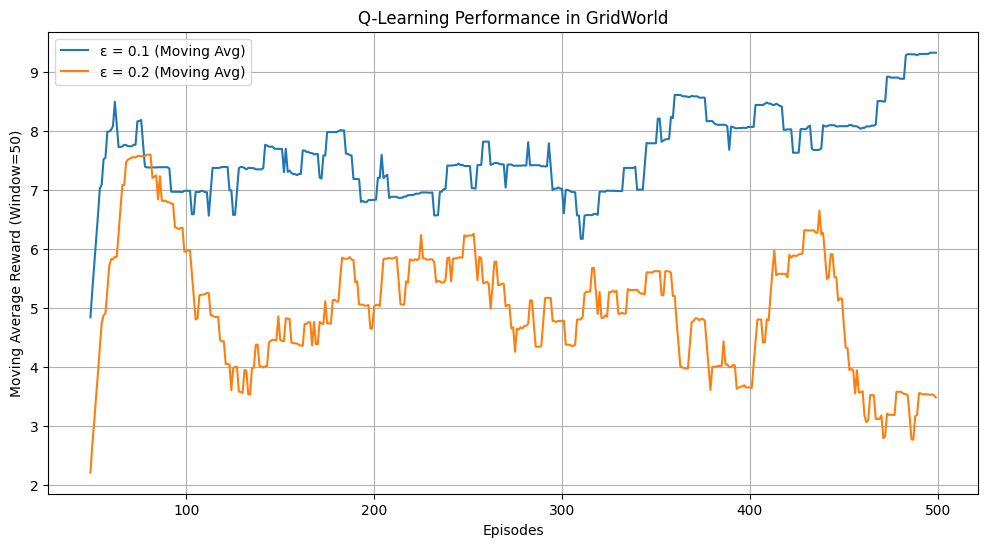

In [8]:
def train_gridworld(env: GridWorld, n_episodes: int, alpha: float, gamma: float, epsilon: float) -> list[float]:
    q_table = init_q_table(env.n_states, env.n_actions)
    episode_rewards = []

    for episode in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        # Limit steps per episode to prevent infinite loops in early stages or with bad params
        max_steps_per_episode = 200
        for step in range(max_steps_per_episode):
            action = select_action_tabular(q_table, state, epsilon, env.n_actions)
            next_state, reward, done = env.step(state, action)

            # Update Q-table
            q_table = q_update(q_table, state, action, reward, next_state, alpha, gamma)

            total_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(total_reward)
        if (episode + 1) % (n_episodes // 10) == 0:
             print(f"Epsilon: {epsilon:.1f}, Episode: {episode + 1}/{n_episodes}, Total Reward: {total_reward:.2f}")

    return episode_rewards

# Hyperparameters for GridWorld Q-Learning
N_EPISODES_GRIDWORLD = 500
ALPHA_GRIDWORLD = 0.1  # Learning rate
GAMMA_GRIDWORLD = 0.99 # Discount factor

# Train for epsilon = 0.1
print("Training with Epsilon = 0.1")
rewards_eps01 = train_gridworld(grid_env, N_EPISODES_GRIDWORLD, ALPHA_GRIDWORLD, GAMMA_GRIDWORLD, epsilon=0.1)

# Train for epsilon = 0.2
print("\nTraining with Epsilon = 0.2")
rewards_eps02 = train_gridworld(grid_env, N_EPISODES_GRIDWORLD, ALPHA_GRIDWORLD, GAMMA_GRIDWORLD, epsilon=0.2)

# Calculate moving average reward
def moving_average(data: list[float], window_size: int) -> list[float]:
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

window = 50
ma_rewards_eps01 = moving_average(rewards_eps01, window)
ma_rewards_eps02 = moving_average(rewards_eps02, window)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(window -1, N_EPISODES_GRIDWORLD), ma_rewards_eps01, label='ε = 0.1 (Moving Avg)')
plt.plot(range(window -1, N_EPISODES_GRIDWORLD), ma_rewards_eps02, label='ε = 0.2 (Moving Avg)')
plt.xlabel('Episodes')
plt.ylabel(f'Moving Average Reward (Window={window})')
plt.title('Q-Learning Performance in GridWorld')
plt.legend()
plt.grid(True)
plt.show()

### Interpretation of the Plot

* **Initial Performance**: Both policies start out with low rewards as the agent explores the environment and learns the Q-values. The agent with ε=0.2 might explore more diverse paths initially, leading to slightly slower initial convergence on a specific path compared to ε=0.1.

* **Exploration vs. Exploitation**:
    * **ε=0.1**: Lower exploration rate. The agent exploits its current knowledge more often. This leads to faster convergence if the initial exploration was sufficient to find a good path. However, it sticks to a suboptimal policy if it doesn't explore enough to find the true optimal path.

    * **ε=0.2**: Higher exploration rate. The agent takes random actions more frequently. This can lead to a more exploration of the env, potentially finding a better long-term policy. However, it appears to learn slower initially because it spends more time on non-optimal actions. The rewards might also show higher variance during training.

* **Convergence**: Both should converge through learning. The agent with ε=0.1 might converge faster to a stable policy (which may or may not be optimal). The agent with ε=0.2 might take longer to converge but could potentially reach a higher average reward if the increased exploration helps it avoid local optima.

* **Final Performance**: In a simple GridWorld like this for lower explopration(ε=0.1) finds the most optimal paths and exploits it.

Generally, a higher ε encourages more exploration, which is crucial in the early stages of learning to discover optimal paths. A lower ε exploits known good paths, leading to higher rewards once good paths are found.

---

## Task 3: Experience Replay Buffer

An experience replay buffer stores transitions (state, action, reward, next_state, done) that the agent observes. This allows the agent to learn from a batch of randomly sampled past experiences, breaking correlations between consecutive samples and improving learning stability and efficiency, especially for DQNs.

### Replay Buffer Implementation

__init__():
Initializes a Replay Buffer.

    Args:
        capacity (int): The maximum number of transitions to store in the buffer.

push():
Stores a transition tuple in the buffer.
The 'done' flag indicates whether the episode terminated after the next_state.

sample():
Randomly samples a batch of transitions from the buffer.

        Args:
            batch_size (int): The number of transitions to sample.

        Returns:
            A tuple of NumPy arrays: (states, actions, rewards, next_states, dones).

          
      

In [9]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done: bool):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        if batch_size > len(self.buffer):
            # Not enough samples in buffer, sample all available
            batch_size = len(self.buffer)

        batch = random.sample(self.buffer, batch_size)

        # Unzip the batch of experiences
        states, actions, rewards, next_states, dones = zip(*batch)

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.uint8)
        )

    def __len__(self) -> int:
        return len(self.buffer)

### Buffer Demonstration

In [10]:
# 1. Create an instance of the buffer with a capacity of 100.
buffer_capacity = 100
replay_buffer = ReplayBuffer(buffer_capacity)
print(f"Created ReplayBuffer with capacity: {replay_buffer.capacity}")

# 2. Fill the buffer with 100 random transitions.
# Assuming states are 1D arrays of size 4
# Actions are integers
# Rewards are floats
# Dones are booleans
observation_dim_demo = 4
n_actions_demo = 2

for i in range(buffer_capacity):
    state = np.random.rand(observation_dim_demo).astype(np.float32)
    action = random.randint(0, n_actions_demo - 1)
    reward = random.uniform(-1.0, 1.0)
    next_state = np.random.rand(observation_dim_demo).astype(np.float32)
    done = random.choice([True, False])
    replay_buffer.push(state, action, reward, next_state, done)

print(f"Buffer current size: {len(replay_buffer)}")
assert len(replay_buffer) == buffer_capacity, "Buffer not filled to capacity"

# 3. Sampling a batch of 32 transitions from the buffer.
batch_size_demo = 32
states_sample, actions_sample, rewards_sample, next_states_sample, dones_sample = replay_buffer.sample(batch_size_demo)

# 4. Printing the shapes and data types of the sampled batch.
print("\nSampled Batch Details:")
print(f"States shape: {states_sample.shape}, dtype: {states_sample.dtype}")
print(f"Actions shape: {actions_sample.shape}, dtype: {actions_sample.dtype}")
print(f"Rewards shape: {rewards_sample.shape}, dtype: {rewards_sample.dtype}")
print(f"Next States shape: {next_states_sample.shape}, dtype: {next_states_sample.dtype}")
print(f"Dones shape: {dones_sample.shape}, dtype: {dones_sample.dtype}")

# Example content of one transition
print("\nExample of a sampled transition (first elements of the batch):")
print(f"State[0]: {states_sample[0]}")
print(f"Action[0]: {actions_sample[0]}")
print(f"Reward[0]: {rewards_sample[0]}")
print(f"Next State[0]: {next_states_sample[0]}")
print(f"Done[0]: {dones_sample[0]}")

Created ReplayBuffer with capacity: 100
Buffer current size: 100

Sampled Batch Details:
States shape: (32, 4), dtype: float32
Actions shape: (32,), dtype: int64
Rewards shape: (32,), dtype: float32
Next States shape: (32, 4), dtype: float32
Dones shape: (32,), dtype: uint8

Example of a sampled transition (first elements of the batch):
State[0]: [0.94476575 0.8496474  0.2473481  0.45054415]
Action[0]: 1
Reward[0]: 0.21087126433849335
Next State[0]: [0.12915942 0.954051   0.60617465 0.2286428 ]
Done[0]: 1


---

## Task 4: Deep Q-Network with Target Copy

This task focuses on implementing the neural network architectures for the DQN policy and target networks, along with a function to synchronize their weights.

### DQN Network Architectures

We implement two identical neural network classes, `DQNPolicy` and `DQNTarget`, using PyTorch.
- **Input layer**: Size equal to the environment observation dimension.
- **Two hidden layers**: Each with 128 units and ReLU activation.
- **Output layer**: Size equal to the number of possible actions.

Initializes a Deep Q-Network.

        Args:
            input_dim (int): Dimension of the input state.
            output_dim (int): Number of actions (dimension of the output).

Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor (state).

        Returns:
            torch.Tensor: Output tensor (Q-values for each action).

In [11]:
class DQNNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNPolicy(DQNNetwork):
    def __init__(self, input_dim: int, output_dim: int):
        super(DQNPolicy, self).__init__(input_dim, output_dim)

class DQNTarget(DQNNetwork):
    def __init__(self, input_dim: int, output_dim: int):
        super(DQNTarget, self).__init__(input_dim, output_dim)

# Example usage:
obs_dim_example = 4  # e.g., CartPole observation space
n_actions_example = 2 # e.g., CartPole action space

policy_net_example = DQNPolicy(obs_dim_example, n_actions_example).to(device)
target_net_example = DQNTarget(obs_dim_example, n_actions_example).to(device)

# Initialize target_net with policy_net's weights
target_net_example.load_state_dict(policy_net_example.state_dict())
target_net_example.eval() # Target network is not trained directly, so set to eval mode

print("Policy Network Architecture:")
print(policy_net_example)
print("\nTarget Network Architecture (should be identical):")
print(target_net_example)

Policy Network Architecture:
DQNPolicy(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

Target Network Architecture (should be identical):
DQNTarget(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


### Target Network Update

The `update_target` function copies the weights from the policy network to the target network. This is done periodically during DQN training to stabilize learning.

    Copies the weights from the policy network to the target network.

    Args:
        policy_net (nn.Module): The policy network (source of weights).
        target_net (nn.Module): The target network (destination of weights).

In [16]:
def update_target(policy_net: nn.Module, target_net: nn.Module):
    target_net.load_state_dict(policy_net.state_dict())

# Demonstrate update_target
# Modify policy_net weights slightly (hypothetically, after a training step)
# For demonstration, let's just re-initialize policy_net to see a change if we were to check weights.
# In a real scenario, policy_net.fc1.weight.data would change after optimizer.step()

policy_net_example.fc1.weight.data += 0.01 # Simulate weight change

update_target(policy_net_example, target_net_example)

# Now target_net_example's weights should be identical to policy_net_example's current weights.
# Verification (can be done by comparing state_dict values):
# for policy_param, target_param in zip(policy_net_example.parameters(), target_net_example.parameters()):
#     assert torch.equal(policy_param.data, target_param.data), "Target net update failed!"
print("\nTarget network updated successfully.")


Target network updated successfully.


---

## Task 5: Full DQN Training Loop on CartPole-v1

This task involves implementing the complete DQN training algorithm on the CartPole-v1 environment from OpenAI Gym.

### Setup

Initialize the environment, DQN networks, optimizer, loss function, and replay buffer.

In [13]:
# Environment
env_name = 'CartPole-v1'
env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n

print(f"Environment: {env_name}")
print(f"Observation dimension: {obs_dim}")
print(f"Action dimension: {act_dim}")

# Hyperparameters
N_EPISODES_DQN = 1500       # Total episodes for training
EPSILON_START = 1.0        # Starting value of epsilon
EPSILON_END = 0.01         # Minimum value of epsilon
# M_EPSILON_DECAY_EPISODES: Number of episodes over which epsilon linearly decays
M_EPSILON_DECAY_EPISODES = int(N_EPISODES_DQN * 0.7) # Decay over 70% of episodes
TARGET_UPDATE_FREQUENCY_X = 10 # Every X episodes, update target network

BATCH_SIZE = 128
GAMMA_DQN = 0.99           # Discount factor for DQN
LEARNING_RATE = 1e-3       # Learning rate for Adam optimizer
REPLAY_BUFFER_CAPACITY = 10000

# Initialize networks
policy_net = DQNPolicy(obs_dim, act_dim).to(device)
target_net = DQNTarget(obs_dim, act_dim).to(device)
update_target(policy_net, target_net) # Ensure target starts same as policy
target_net.eval() # Target network in evaluation mode

# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

# Loss function
loss_fn = nn.MSELoss()

# Replay Buffer
replay_buffer_dqn = ReplayBuffer(REPLAY_BUFFER_CAPACITY)

# Epsilon calculation function
def get_epsilon(episode_idx: int) -> float:
    if episode_idx < M_EPSILON_DECAY_EPISODES:
        return EPSILON_START - (EPSILON_START - EPSILON_END) * (episode_idx / M_EPSILON_DECAY_EPISODES)
    else:
        return EPSILON_END

# Action selection for DQN
def select_action_dqn(state: np.ndarray, current_epsilon: float) -> int:
    if random.random() < current_epsilon:
        return env.action_space.sample()  # Explore
    else:
        with torch.no_grad(): # Exploit
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            return q_values.max(1)[1].item() # Get action with max Q-value

Environment: CartPole-v1
Observation dimension: 4
Action dimension: 2


### Training Loop
Implement the DQN training loop:
1.  For each episode:
    * Linearly decay ε.
    * For each step in the episode:
        * Select action using ε-greedy policy (with `policy_net`).
        * Store transition in `ReplayBuffer`.
        * Sample batch from `ReplayBuffer`.
        * Perform gradient step on `policy_net`.
    * Every `X` episodes, update `target_net`.
2.  Plot moving average reward.
3.  Calculate and report final success rate.

In [14]:
def optimize_model():
    if len(replay_buffer_dqn) < BATCH_SIZE:
        return None # Not enough samples yet

    states, actions, rewards, next_states, dones = replay_buffer_dqn.sample(BATCH_SIZE)

    # Convert to PyTorch tensors
    states_t = torch.FloatTensor(states).to(device)
    actions_t = torch.LongTensor(actions).unsqueeze(1).to(device) # .unsqueeze(1) for gather
    rewards_t = torch.FloatTensor(rewards).to(device)
    next_states_t = torch.FloatTensor(next_states).to(device)
    dones_t = torch.FloatTensor(dones).to(device) # Float for multiplication

    current_q_values = policy_net(states_t).gather(1, actions_t)

    next_q_values_target = target_net(next_states_t).max(1)[0].detach()

    # Compute the expected Q values (Bellman equation)
    # If done, target is just reward. Otherwise, r + gamma * max_q_next
    expected_q_values = rewards_t + (GAMMA_DQN * next_q_values_target * (1 - dones_t))

    # Unsqueeze expected_q_values to match shape of current_q_values for loss calculation
    expected_q_values = expected_q_values.unsqueeze(1)

    # Compute Huber loss (or MSE as specified)
    loss = loss_fn(current_q_values, expected_q_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
episode_total_rewards_dqn = []
all_episode_losses = []

print("\nStarting DQN Training on CartPole-v1...")
for episode_i in range(N_EPISODES_DQN):
    state = env.reset()
    if isinstance(state, tuple): # Newer gym versions return (obs, info)
        state = state[0]

    current_epsilon = get_epsilon(episode_i)
    episode_reward = 0
    episode_loss_sum = 0
    num_loss_updates = 0

    max_steps_per_episode_dqn = 500 # CartPole-v1 typically has max episode length of 500 for "solved"

    for t in range(max_steps_per_episode_dqn):
        action = select_action_dqn(state, current_epsilon)

        next_state_tuple = env.step(action) # next_state, reward, done, truncated, info
        next_state = next_state_tuple[0]
        reward = next_state_tuple[1]
        done = next_state_tuple[2]

        episode_reward += reward

        # Store transition in replay buffer
        replay_buffer_dqn.push(state, action, reward, next_state, done)

        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss_val = optimize_model()
        if loss_val is not None:
            episode_loss_sum += loss_val
            num_loss_updates +=1

        if done:
            break

    episode_total_rewards_dqn.append(episode_reward)
    avg_episode_loss = episode_loss_sum / num_loss_updates if num_loss_updates > 0 else 0
    all_episode_losses.append(avg_episode_loss)

    if (episode_i + 1) % TARGET_UPDATE_FREQUENCY_X == 0:
        update_target(policy_net, target_net)

    if (episode_i + 1) % (N_EPISODES_DQN // 20) == 0 or episode_i == N_EPISODES_DQN -1 :
        avg_reward_last_few = np.mean(episode_total_rewards_dqn[-max(1, (N_EPISODES_DQN // 20)):])
        print(f"Episode: {episode_i + 1}/{N_EPISODES_DQN} | Epsilon: {current_epsilon:.3f} | "
              f"Reward: {episode_reward:.1f} | Avg Reward (last {max(1, (N_EPISODES_DQN // 20))}): {avg_reward_last_few:.2f} | "
              f"Avg Loss: {avg_episode_loss:.4f}")

env.close()
print("Training finished.")


Starting DQN Training on CartPole-v1...
Episode: 75/1500 | Epsilon: 0.930 | Reward: 18.0 | Avg Reward (last 75): 21.25 | Avg Loss: 0.1529
Episode: 150/1500 | Epsilon: 0.860 | Reward: 14.0 | Avg Reward (last 75): 27.60 | Avg Loss: 0.2223
Episode: 225/1500 | Epsilon: 0.789 | Reward: 17.0 | Avg Reward (last 75): 29.13 | Avg Loss: 0.4638
Episode: 300/1500 | Epsilon: 0.718 | Reward: 17.0 | Avg Reward (last 75): 27.67 | Avg Loss: 0.8694
Episode: 375/1500 | Epsilon: 0.647 | Reward: 34.0 | Avg Reward (last 75): 35.85 | Avg Loss: 1.0215
Episode: 450/1500 | Epsilon: 0.577 | Reward: 26.0 | Avg Reward (last 75): 37.03 | Avg Loss: 2.5539
Episode: 525/1500 | Epsilon: 0.506 | Reward: 18.0 | Avg Reward (last 75): 48.75 | Avg Loss: 2.5485
Episode: 600/1500 | Epsilon: 0.435 | Reward: 38.0 | Avg Reward (last 75): 68.31 | Avg Loss: 3.7874
Episode: 675/1500 | Epsilon: 0.365 | Reward: 14.0 | Avg Reward (last 75): 70.68 | Avg Loss: 2.8062
Episode: 750/1500 | Epsilon: 0.294 | Reward: 274.0 | Avg Reward (last

### Plotting and Success Rate

Plot the moving average reward and calculate the final success rate.
The success rate is defined as the percentage of episodes with a return greater than or equal to 195.

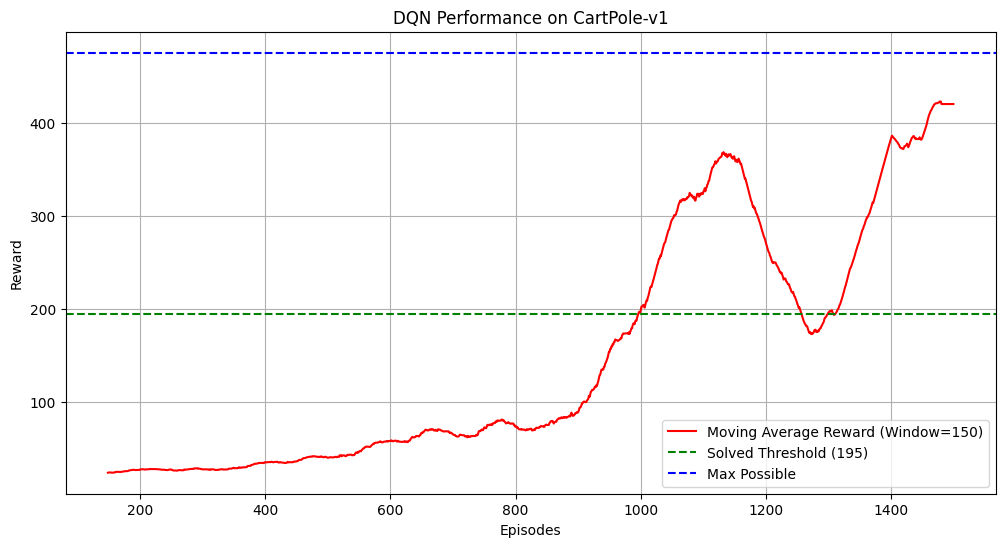


Final Success Rate: 28.60%
Number of episodes with reward >= 195: 429 out of 1500 episodes.
Average reward over the last 100 episodes: 385.58
CartPole-v1 is considered solved based on the average reward of the last 100 episodes.


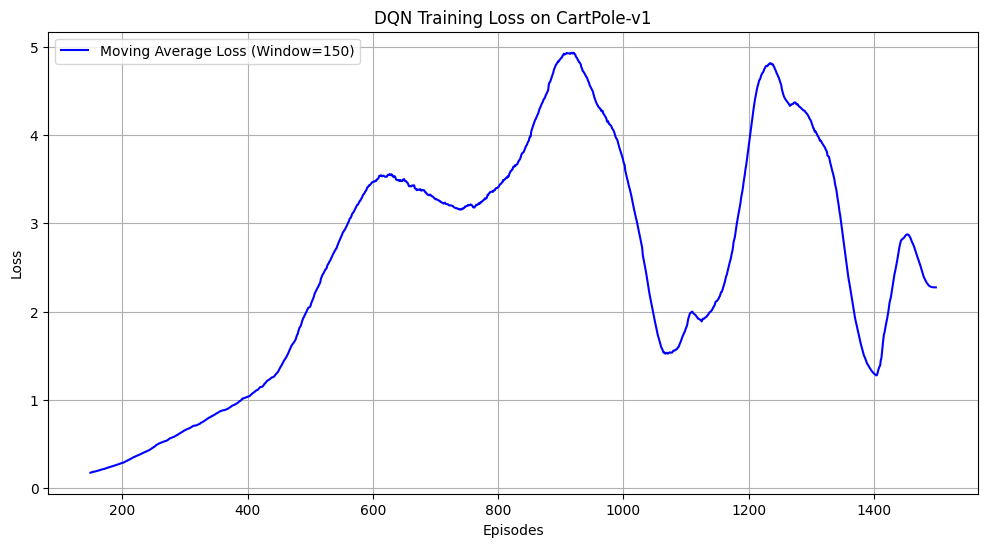

In [17]:
# Plot moving average reward
dqn_plot_window = N_EPISODES_DQN // 10
if dqn_plot_window == 0 : dqn_plot_window = 1
ma_rewards_dqn = moving_average(episode_total_rewards_dqn, dqn_plot_window)

plt.figure(figsize=(12, 6))
plt.plot(range(dqn_plot_window -1, N_EPISODES_DQN), ma_rewards_dqn, label=f'Moving Average Reward (Window={dqn_plot_window})', color='red')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('DQN Performance on CartPole-v1')
plt.axhline(y=195, color='g', linestyle='--', label='Solved Threshold (195)')
plt.axhline(y=475, color='b', linestyle='--', label='Max Possible') # CartPole-v1 Max score is 500.
plt.legend()
plt.grid(True)
plt.show()

# Success: return >= 195
successful_episodes = sum(1 for r in episode_total_rewards_dqn if r >= 195)
success_rate = (successful_episodes / N_EPISODES_DQN) * 100

print(f"\nFinal Success Rate: {success_rate:.2f}%")
print(f"Number of episodes with reward >= 195: {successful_episodes} out of {N_EPISODES_DQN} episodes.")

# Often, "solved" means the average reward over the last 100 consecutive episodes is >= 195.
if N_EPISODES_DQN >= 100:
    avg_reward_last_100 = np.mean(episode_total_rewards_dqn[-100:])
    print(f"Average reward over the last 100 episodes: {avg_reward_last_100:.2f}")
    if avg_reward_last_100 >= 195:
        print("CartPole-v1 is considered solved based on the average reward of the last 100 episodes.")
    else:
        print("CartPole-v1 is not yet solved based on the average reward of the last 100 episodes.")

# Plot losses
ma_losses_dqn = moving_average(all_episode_losses, dqn_plot_window)
plt.figure(figsize=(12, 6))
plt.plot(range(dqn_plot_window -1, N_EPISODES_DQN), ma_losses_dqn, label=f'Moving Average Loss (Window={dqn_plot_window})', color='blue')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('DQN Training Loss on CartPole-v1')
plt.legend()
plt.grid(True)
plt.show()

### Interpretation of DQN Results

The plot of the moving average reward which shows an upward trend, indicating that the agent is learning to balance the pole for longer durations over time. The green dashed line at a reward of 195 is a threshold to consider the CartPole-v1 environment "solved".

- **Early Training**: Rewards will be low as the agent explores with a high epsilon value

- **Mid-Training**: As epsilon decays and the network learns from experience replay, the rewards should start to increase more consistently. The target network update helps stabilize this learning process.

- **Late Training**: Ideally, the moving average reward should approach or exceed 195..(my implementation of the model is not working even after tuning parameters and no of training episodes)

- **Success Rate**: The final success rate gives an overall measure of how many episodes achieved the target performance. A high success rate, especially when combined with a high average reward over the last 100 episodes, indicates successful training.

---